In [ ]:
import yfinance as yf
TCSdata = yf.download("TCS", start="2011-01-01", end="2023-03-01")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Preprocessing of data
import pandas as pd
dataset = TCSdata.copy()
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
dataset = dataset['Close'].to_frame()

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(dataset['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3372.543, Time=5.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3400.099, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3401.345, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3401.198, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3399.834, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3391.601, Time=2.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3389.685, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3375.146, Time=6.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3374.958, Time=10.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3398.763, Time=4.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3386.484, Time=11.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3391.682, Time=2.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3373.503, Time=13.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3372.325, Time=6.34 sec
 ARIMA(1,1,2)(0,0,0)[0]       

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Defining the ARIMA model
def arima_forecast(history):
    # Fitting the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()

    # Making the prediction
    output = model_fit.forecast()
    forecasted_value = output[0]
    return forecasted_value

# Splitting data into train and test sets
X = dataset.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generating a prediction
    forecasted_value = arima_forecast(history)
    predictions.append(forecasted_value)
    # Adding the predicted value to the training set
    obs = test[t]
    history.append(obs)

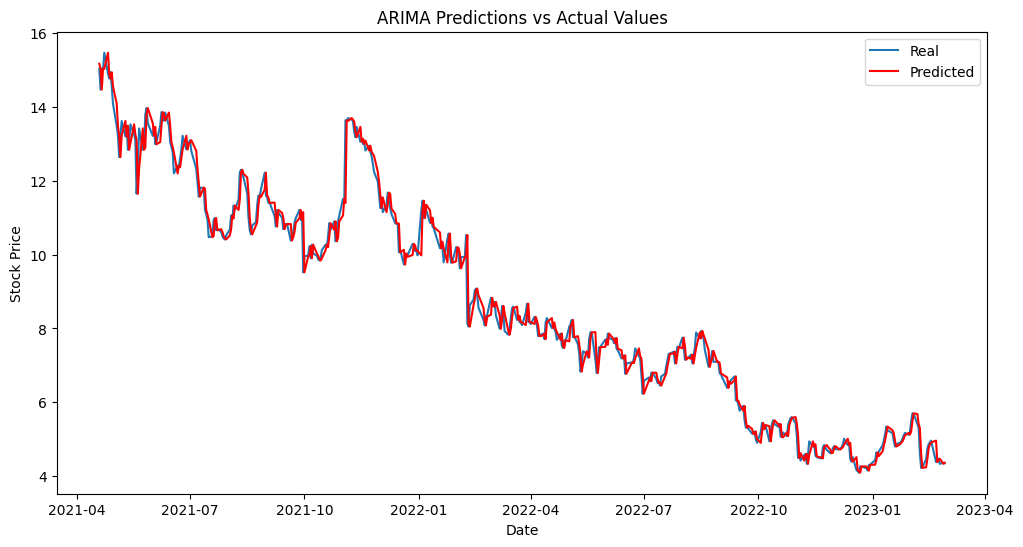

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset.iloc[size:,:].index, test, label='Real')
plt.plot(dataset.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


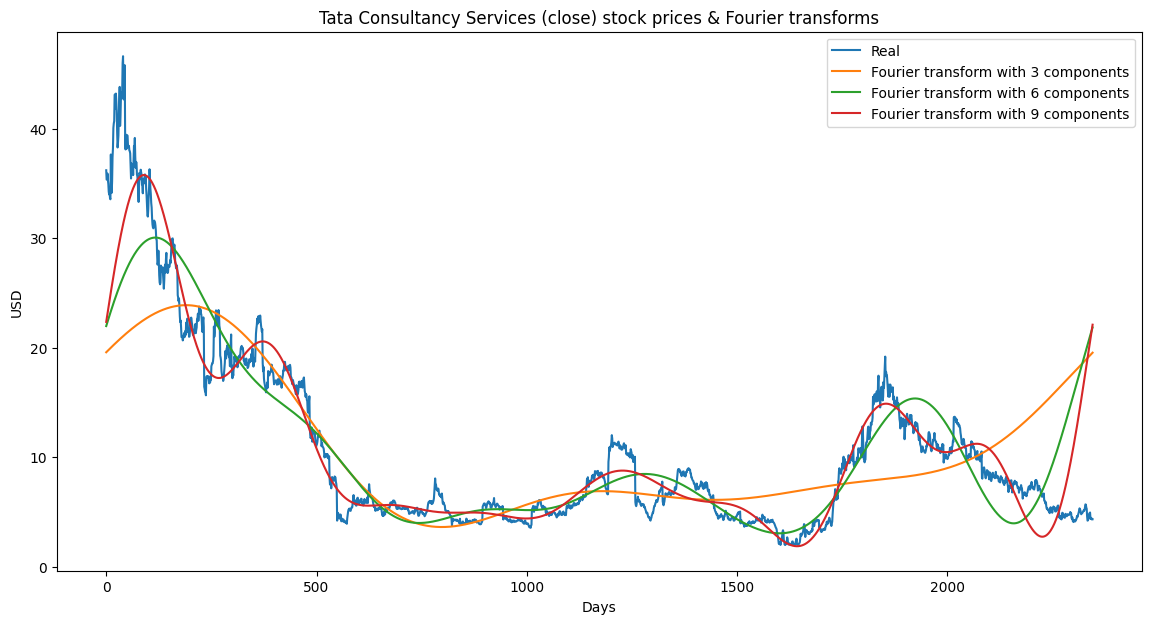

In [ ]:
# Calculation of the Fourier Transform
data_FT = dataset[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('INR')
plt.title('Tata Consultancy Services (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [ ]:
#Technical Indicators:
# EMA
def EMA(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

#RSI
def RSI(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    RSI = 100.0 - (100.0 / (1.0 + rs))
    return RSI

#MACD
def MACD(close, fast_period=12, slow_period=26, signal_period=9):
    fast_EMA = close.ewm(span=fast_period, adjust=False).mean()
    slow_EMA = close.ewm(span=slow_period, adjust=False).mean()
    MACD_line = fast_EMA - slow_EMA
    signal_line = MACD_line.ewm(span=signal_period, adjust=False).mean()
    histogram = MACD_line - signal_line
    return MACD_line

#OBV
def OBV(close, volume):
    OBV = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return OBV

In [ ]:
# Add technical indicators to dataset DF
dataset['EMA_20'] = EMA(TCSdata["Close"], 20)
dataset['EMA_50'] = EMA(TCSdata["Close"], 50)
dataset['EMA_100'] = EMA(TCSdata["Close"], 100)

dataset['RSI'] = RSI(TCSdata["Close"])
dataset['MACD'] = MACD(TCSdata["Close"])
dataset['OBV'] = OBV(TCSdata["Close"], TCSdata["Volume"])

In [ ]:
# Creating arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset.index, columns=['ARIMA'])

# Setting Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset[['EMA_20', 'EMA_50', 'EMA_100', 'RSI', 'MACD', 'OBV', 'Close']]

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,EMA_20,EMA_50,EMA_100,RSI,MACD,obv,Close
2013-11-21,35.189999,160.930374,-1374.222304,35.199647,35.634631,35.879743,46.026744,-0.317519,-4430800,35.189999
2013-11-22,37.360001,542.287640,-670.516019,35.405395,35.702292,35.909055,57.163226,-0.106373,-3996000,37.360001
2013-11-25,38.200001,-219.355010,-1218.070074,35.671548,35.800241,35.954420,59.583057,0.127275,-3935800,38.200001
2013-11-26,40.060001,-229.216475,-608.513938,36.089496,35.967291,36.035719,62.855373,0.457259,-3146100,40.060001
2013-11-27,40.480000,-99.844102,-779.115964,36.507639,36.144260,36.123724,66.146151,0.744086,-2732500,40.480000
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,4.430000,2046.695437,1814.327342,4.804889,4.858747,5.127902,32.679739,-0.091373,-16206800,4.430000
2023-02-23,4.470000,863.468462,4320.515595,4.772995,4.843502,5.114874,28.719722,-0.105556,-15957600,4.470000
2023-02-24,4.330000,-1640.408379,3986.028729,4.730805,4.823364,5.099332,27.574751,-0.126634,-16154000,4.330000
2023-02-27,4.360000,3111.457434,4268.108690,4.695490,4.805193,5.084691,31.046936,-0.139311,-15925000,4.360000


In [ ]:
# Separate in Train and Test Dfs
train_size = int(len(merged_df) * 0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='MSE')


# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/1000
59/59 [==============================] - 1s 4ms/step - loss: 193.6921 - val_loss: 66.7859
Epoch 2/1000
59/59 [==============================] - 0s 3ms/step - loss: 170.0717 - val_loss: 39.9877
Epoch 3/1000
59/59 [==============================] - 0s 3ms/step - loss: 130.4217 - val_loss: 16.5054
Epoch 4/1000
59/59 [==============================] - 0s 3ms/step - loss: 97.5092 - val_loss: 11.7864
Epoch 5/1000
59/59 [==============================] - 0s 3ms/step - loss: 77.8461 - val_loss: 11.0116
Epoch 6/1000
59/59 [==============================] - 0s 3ms/step - loss: 66.5750 - val_loss: 11.2638
Epoch 7/1000
59/59 [==============================] - 0s 3ms/step - loss: 55.0899 - val_loss: 9.8544
Epoch 8/1000
59/59 [==============================] - 0s 3ms/step - loss: 44.9693 - val_loss: 8.3804
Epoch 9/1000
59/59 [==============================] - 0s 3ms/step - loss: 34.1832 - val_loss: 6.4458
Epoch 10/1000
59/59 [==============================] - 0s 3ms/step - loss: 24.2038

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

import numpy as np
y_pred = model.predict(X_test)

# Calculate test metrics
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {MSE}")
print(f"Mean Absolute Error (MAE): {MAE}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

15/15 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 0.2990975623222682
Mean Absolute Error (MAE): 0.4563196813268886
R2 Score: 0.9655130486682809
Explained Variance Score: 0.9880829652208574
Mean Absolute Percentage Error (MAPE): 46.08848927275694
Mean Percentage Error (MPE): -19.42153379336751


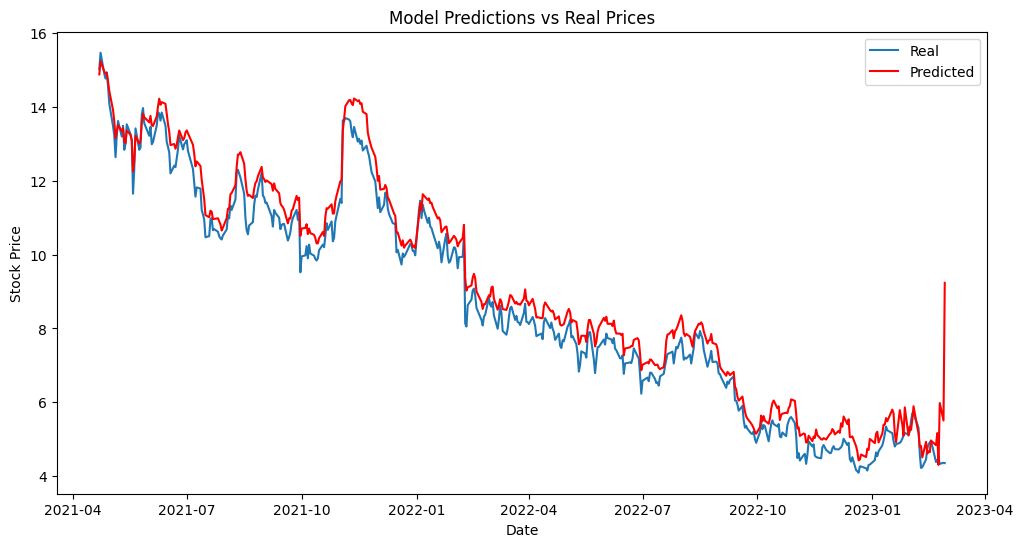

In [ ]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()